In [1]:
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ajouter tree-specie
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok


#preprocessing bdiff:
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

In [2]:
#autoreload 
from attribution import Attribution

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 1000}),
        'temporal': ('weighting_function', {'x0': 30, 'k': 365})
    },
    'hm': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 1000}),
        'temporal': ('weighting_function', {'x0': 30, 'k': 365})
    },
    'nfi': {
        'spatial': ('weighting_function', {'x0': 600, 'k': 1500}),
        'temporal': ('weighting_function', {'x0': 365, 'k': 2.5 * 365})
    },
    'senfseidl': {
        'spatial': ('weighting_function', {'x0': 30, 'k': 100}),
        'temporal': ('weighting_function', {'x0': 180, 'k': 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 1000}),
        'temporal': ('weighting_function', {'x0': 1, 'k': 90})
    },
    'cdi': {
        'spatial': ('weighting_function', {'x0': 5000, 'k': 5000}),
        'temporal': ('weighting_function', {'x0': 10, 'k': 90})
    },
    'forms': {
        'spatial': ('weighting_function', {'x0': 30, 'k': 100}),
        'temporal': ('weighting_function', {'x0': 90, 'k': 180})
    },
    'reference': {
        'spatial': ('weighting_function', {'x0': 30, 'k': 100}),
        'temporal': ('weighting_function', {'x0': 30, 'k': 365})
    }
}


ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('exponential_decay', {'x0': 0, 'k': 0.0025})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 100}),
        'temporal': ('exponential_decay', {'x0': 0, 'k': 0.005})
    },
    'anthropogenic': {
        'spatial': ('step', {'start': 0, 'end': 250}),
        'temporal': ('step', {'start': 0, 'end': 365})
    }
}

# dspatial_f = {'dfde': (3000, 0), 'hm': (1000, 0), 'nfi': (3000, 600), 'senfseidl': (500, 0), 'bdiff': (500, 0), 'cdi':(3000, 0), 'forms':(500, 0)}
# dtemporal_f = {'dfde': (365, 0), 'hm': (180, 0), 'nfi': (2.5 * 365, 0), 'senfseidl': (180, 0), 'bdiff': (180, 0), 'cdi':(180, 0), 'forms':(180, 0)} 

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': 1., 'bdiff': 1.0, 'cdi':.5, 'forms':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100}

from constants import DCLASS_SCORE

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=7, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 451.88 km2, median : 25.00 km2


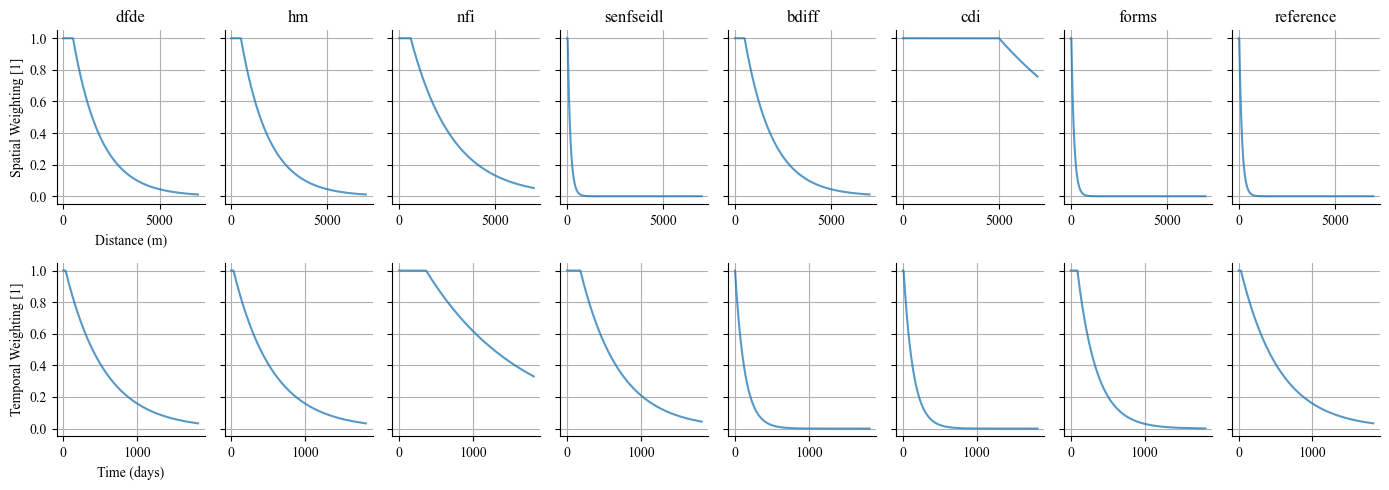

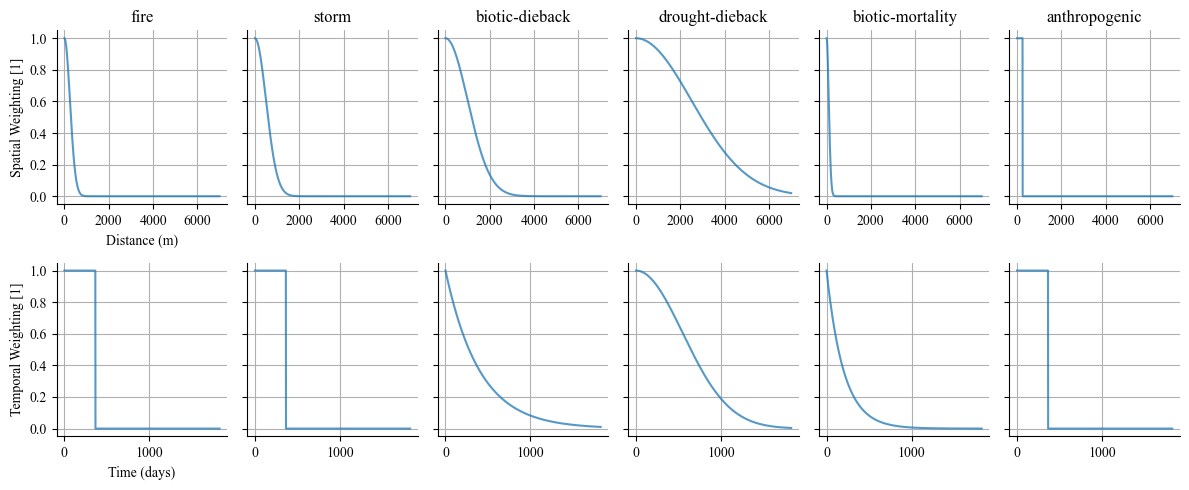

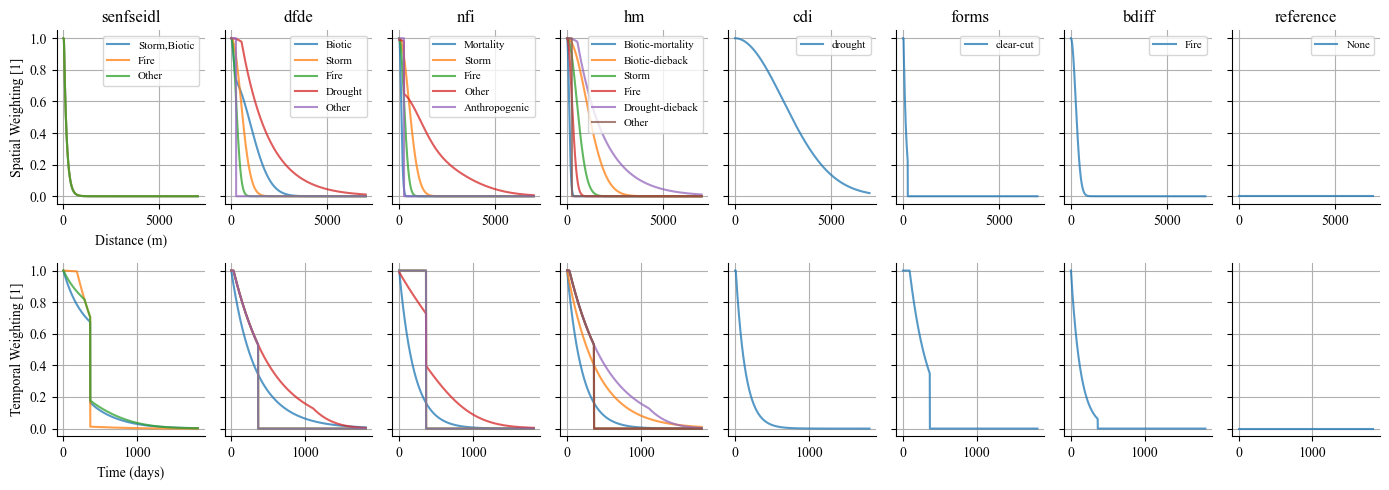

In [3]:
attribution.plot_weighting_functions()

In [3]:
import geopandas as gpd 
import pandas as pd
df = gpd.read_file('../GoogleEarth/example_article.geojson').to_crs('EPSG:2154').iloc[1:]
df['start_date'] = [2014, 2014, 2014, 2012, 2010, 2013]
df['end_date'] = [2014, 2014, 2014, 2017, 2015, 2014]
df['essence'] = ['Spruce', 'Spruce', 'Fir', 'Spruce', 'Beech', 'Mixed']
df['tree_type'] = ['Coniferous', 'Coniferous', 'Coniferous', 'Coniferous', 'Broadleaf', 'Mixed']
df['class'] = ['Other', 'None', 'Biotic-dieback', 'Mortality', 'Other', 'Biotic']
df['dataset'] = ['senfseidl', 'reference', 'hm', 'nfi', 'nfi', 'dfde']
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y') + pd.offsets.YearEnd(0)
df

#swith first and seconf row 
df.iloc[[0,1]] = df.iloc[[1,0]].values

#reverse third to last row
df.iloc[2:-1] = df.iloc[2:-1].values[::-1]
df

,Name,geometry,start_date,end_date,essence,tree_type,class,dataset
1,Hansen,"POLYGON ((681697.219 6470339.281, 681709.777 6...",2014-01-01,2014-12-31,Spruce,Coniferous,None,reference
2,SenfSeidl,"POLYGON ((681915.926 6470334.402, 681814.893 6...",2014-01-01,2014-12-31,Spruce,Coniferous,Other,senfseidl
3,NFI1,POINT (676875.068 6473063.857),2010-01-01,2015-12-31,Beech,Broadleaf,Other,nfi
4,NFI2,POINT (687446.035 6471676.032),2012-01-01,2017-12-31,Spruce,Coniferous,Mortality,nfi
5,HM,POINT (681504.825 6466107.819),2014-01-01,2014-12-31,Fir,Coniferous,Biotic-dieback,hm
6,DFDE,"POLYGON ((685466.221 6470793.369, 674638.443 6...",2013-01-01,2014-12-31,Mixed,Mixed,Biotic,dfde


In [11]:
df = gpd.read_parquet('/Users/arthurcalvi/Repo/Disturbance-Attribution-Dataset-Joining/data/results/cluster_2018/disturbances_2018_g7_v0.2.parquet')

In [13]:
groups = df.groupby('index_reference')

In [16]:
from itertools import islice
list_groups = []
for name, group in islice(groups, 100):
    list_groups.append(group)

In [78]:
data = list_groups[26]
data

,index,index_reference,geometry,year,tree_type,essence,class,start_date,end_date,dataset,cause,essence_bdforet,forest_area_m2,intensity,severity,name,notes,ref_dfde,sd
8855,570071,570071,"POLYGON ((664631.919 7078294.457, 664631.742 7...",2018.0,Mixed,"fir, spruce,mixed,poplar",<NA>,2018-01-01,2018-12-31,reference,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN
8856,35975,570071,"POLYGON ((664610.159 7078268.901, 664650.159 7...",NaN,Mixed,"mixed,poplar",clear-cut,2018-09-01,2019-05-01,forms,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,0.000000
8857,38822,570071,POINT (661806.953 7078701.638),2017.0,broadleaf,Oaks,Biotic-dieback,2017-01-01,2017-12-31,hm,Phytophthora spp,<NA>,NaN,NaN,3,<NA>,"Seuls deux arbres ont été observés sur 1,5 ha ...",NaN,2805.695589
8858,38823,570071,POINT (661831.769 7078612.299),2017.0,broadleaf,Beech,Biotic-dieback,2017-01-01,2017-12-31,hm,Phytophthora spp,<NA>,NaN,NaN,3,<NA>,plantation de 22 ans environ sur sol argileux....,NaN,2768.624912
8859,47320,570071,"POLYGON ((664700.877 7078195.945, 664730.821 7...",2018.0,Mixed,"mixed,poplar",Other,2018-01-01,2018-12-31,senfseidl,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,0.000000
8860,54585,570071,POINT (664732.703 7078180.798),2020.0,conifer,Spruces,Biotic-mortality,2020-01-01,2020-12-31,hm,Scolytes (espèce indéterminée),<NA>,NaN,NaN,4,<NA>,Epicea de 1976 non entretenus,NaN,13.208813
8861,4219658,570071,"POLYGON ((664599.580 7078306.866, 664629.523 7...",2019.0,Mixed,"mixed,poplar,fir, spruce","Storm,Biotic",2019-01-01,2019-12-31,senfseidl,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,0.000000
8862,5022716,570071,"POLYGON ((664745.154 7078049.356, 664742.288 7...",2018.0,Mixed,"mixed,poplar","Storm,Biotic",2018-01-01,2018-12-31,senfseidl,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,0.000000


<Axes: >

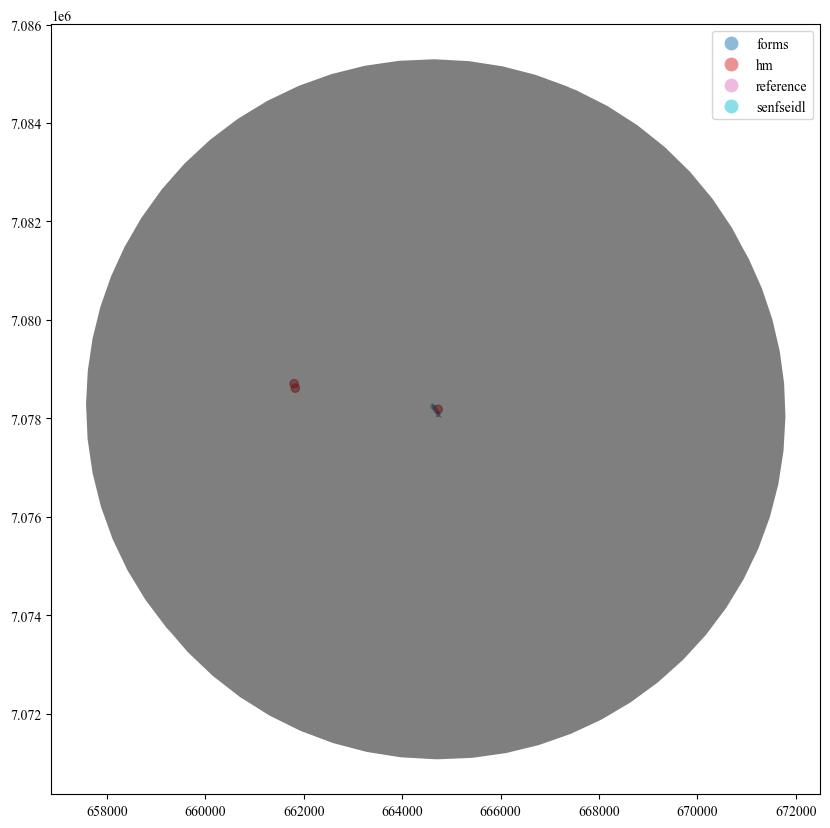

In [79]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
data.plot(ax =ax, column='dataset', legend=True, cmap='tab10', alpha=0.5)
#plot dataset = refrence with buffer of 7km
data[data.dataset == 'reference'].buffer(7000).plot(ax=ax, color='k', alpha=0.5, linestyle='--')

AttributeError: 'GeoDataFrame' object has no attribute 'Name'

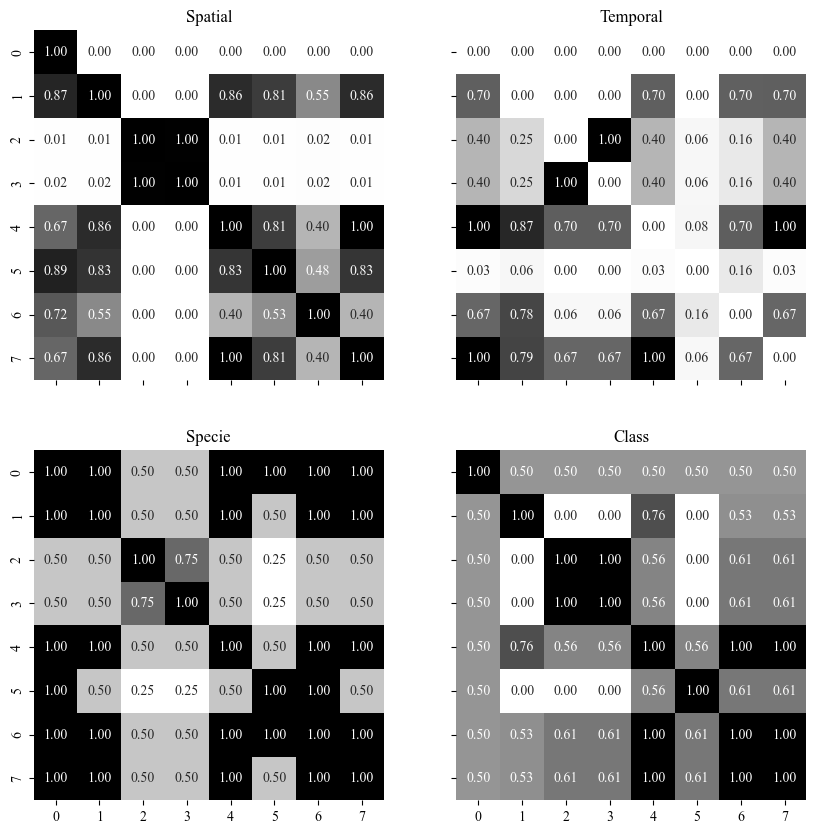

In [80]:
from utils import compute_similarity_matrix, compute_tree_coherence, compute_class_similarity

import seaborn as sns
import matplotlib.pyplot as plt
#change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
similarity_matrix, matrices = compute_similarity_matrix(data, attribution.dtypes_, {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (compute_class_similarity, {'dclass_score': attribution.dclass_score}, 1.0)}, final_weighting_dict=attribution.final_weighting_dict)
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

dname = {
    'spatial': 'Spatial',
    'temporal': 'Temporal',
    'tree specie relatedness': 'Specie',
    'class relatedness': 'Class'
}

#set the colormap for each matrix, the figure is for an article so we use a colorblind friendly colormap, I want cmap that start form white
#use another cmap than Greys
dcmap = {
    'spatial': 'Greys',
    'temporal': 'Greys',
    'tree specie relatedness': 'Greys',
    'class relatedness': 'Greys'
}



axes_ = [ (0,0), (0,1), (1,0), (1,1) ]

for ax, (name, matrices) in zip(axes_, matrices.items()):
    axes[ax].set_title(dname[name])
    sns.heatmap(matrices, annot=True, cmap='Greys', square=True, ax=axes[ax], cbar=False, fmt='.2f')

#set xticks and yticks as the dataset name with 45° rotation
for ax in axes_:
    axes[ax].set_xticklabels(data.Name, rotation=45)
    axes[ax].set_yticklabels(data.Name, rotation=45)




<Axes: >

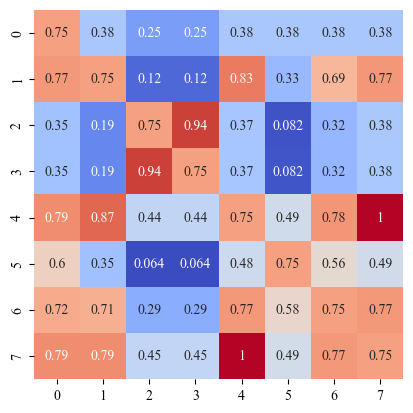

In [81]:
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', square=True, cbar=False)

In [82]:
from utils import get_cluster
data['index_reference'] = 730
get_cluster(data,  {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 
                    'class relatedness': (compute_class_similarity, {'dclass_score': attribution.dclass_score}, 1.0)},
                      attribution.dtypes_, 
                      attribution.final_weighting_dict , 
                      attribution.doa, 
                      attribution.dclass_score, 
                        threshold=0.)

,Similarity,Class,Start_Date,End_Date,index_reference
0,0.375,biotic-mortality,2019-01-01,2020-12-31,730
3,0.375,anthropogenic,2018-01-01,2019-05-01,730
1,0.250,biotic-dieback,2017-01-01,2017-12-31,730
